# Case Study: ARIMA Modeling for Energy Data

In this notebook, we do a back of the envelope case study to see if we can accurately model energy demand

Our goal will be to use the data from 2017 to 2020 and see whether we can accurately predict energy demand for _all_ of 2021!

In [1]:
import requests
import zipfile

from io import BytesIO

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

## Data

We will return to our ERCOT load data.

Recall that this data represents the hourly energy demand in various regions of Texas.

We will aggregate it to daily totals and try to predict daily totals

In [2]:
# Run this code if you need to download the data
# from bs4 import BeautifulSoup

# base_url = "https://www.ercot.com/gridinfo/load/load_hist"

# ercot_bs = BeautifulSoup(requests.get(base_url).text)

# relevant_links = []
# for link in ercot_bs.find_all("a"):
#     link_text = link.text.lower()

#     if ("hourly load data" in link_text) and ("archives" not in link_text):
#         href = link.attrs["href"]

#         year = href.split("/")[5]
#         if int(year) > 2017:
#             relevant_links.append(href)

# load_dfs = []
# for link in relevant_links:
#     res = requests.get(link)
#     zf = zipfile.ZipFile(BytesIO(res.content))
#     load_dfs.append(
#         pd.read_excel(
#             zf.read(zf.filelist[0].filename),
#             engine="openpyxl"
#         ).rename(
#             columns={
#                 "HourEnding": "dt",
#                 "Hour Ending": "dt"
#             }
#         )
#     )

# load = pd.concat(load_dfs)

# # Convert hours from 1-24 to 0-23
# for i in range(24):
#     old, new = f"{i+1:02}:00", f"{i:02}:00"
#     load["dt"] = load["dt"].str.replace(old, new)
# load["dt"] = pd.to_datetime(load["dt"])
# load = load.set_index("dt").resample("D").sum()

# load.head()
# load.to_parquet("load_2017_2022.parquet")

/home/chase/anaconda3/envs/teaching/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname DST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
load = pd.read_parquet("load_2017_2022.parquet").loc["2017":"2020"]

load.head()

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
dt,,,,,,,,,
2017-01-01,220989.383769,22767.792809,48414.461340,16449.489607,237387.964848,61834.544360,114045.539678,23149.421088,7.450386e+05
2017-01-02,235680.356298,23894.443988,50876.911150,16097.980569,235419.578465,69387.296300,120059.924455,23259.831731,7.746763e+05
2017-01-03,237534.034376,28185.883381,51724.814944,19703.705189,282792.026450,66839.009216,126830.840035,25298.580736,8.389089e+05
2017-01-04,247560.221660,36225.329657,54063.371042,23158.561427,362278.271965,65501.676791,151975.235566,29223.149235,9.699858e+05
2017-01-05,251129.285144,35668.737617,57687.098929,25004.639118,385921.482278,67833.477206,146763.600251,30357.418584,1.000366e+06


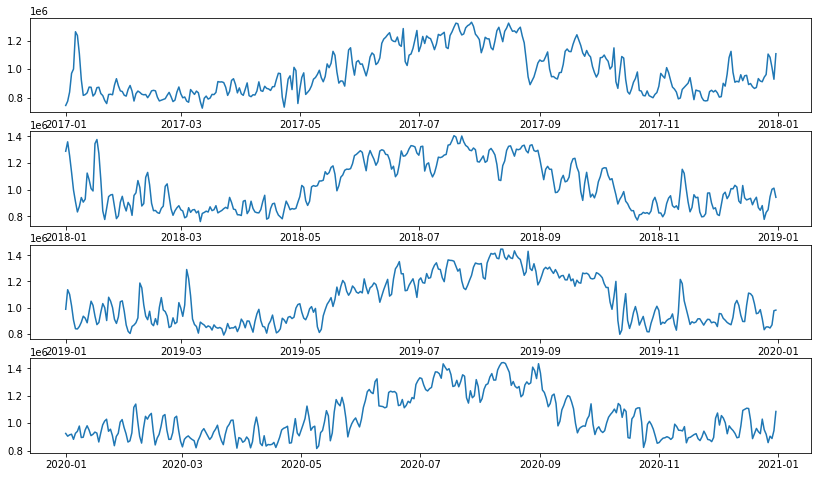

In [4]:
years = load.index.year.unique().values

fig, ax = plt.subplots(years.size, figsize=(14, 8))
for (iy, year) in enumerate(years):
    bs = ((load.index.year == year))
    ax[iy].plot(load.loc[bs, "ERCOT"])


## Computing the trend

We will assume a linear (in time) trend

In [5]:
nobs = load.shape[0]
trend_tvalues = np.arange(nobs)

mod_trend = LinearRegression(fit_intercept=True)
mod_trend.fit(trend_tvalues[:, None], load["ERCOT"])

load["ERCOT_trend"] = mod_trend.predict(trend_tvalues[:, None])
load["ERCOT_trend_removed"] = load.eval("ERCOT - ERCOT_trend")

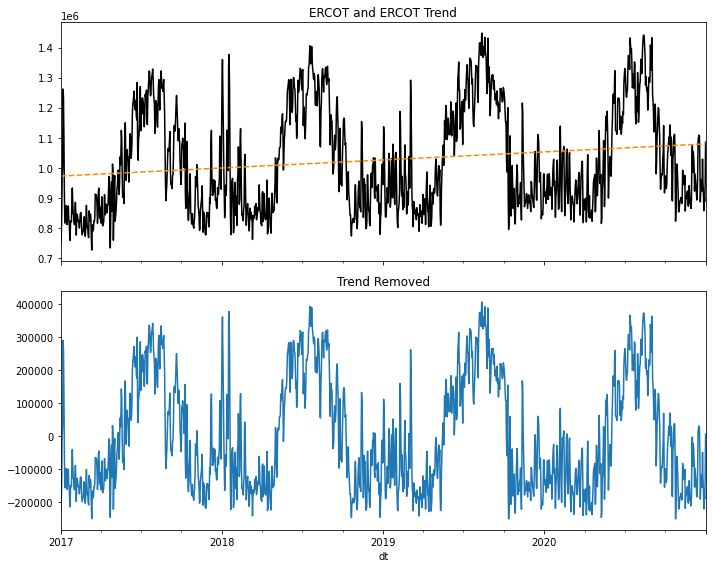

In [6]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

load.plot(y="ERCOT", ax=ax[0], color="k", legend=False)
load.plot(y="ERCOT_trend", ax=ax[0], color="DarkOrange", linestyle="--", legend=False)
ax[0].set_title("ERCOT and ERCOT Trend")

load.plot(y="ERCOT_trend_removed", ax=ax[1], legend=False)
ax[1].set_title("Trend Removed")

fig.tight_layout()

## Computing seasonal elements

For the monthly and day of week seasonality, we will use the seasonal fixed effects model

**Monthly seasonality**

In [7]:
# Get fixed effect values for each "season" of our choosing
months = list(range(1, 13))
month_cols = [f"month_{i}" for i in months]

for month in month_cols:
    _, i = month.split("_")
    i = int(i)
    load[month] = (load.index.month == i).astype(int)


In [8]:
mod_seas_m = LinearRegression(fit_intercept=False)
mod_seas_m.fit(load.loc[:, month_cols], load["ERCOT_trend_removed"])

load["ERCOT_mseasonal"] = mod_seas_m.predict(load.loc[:, month_cols])
load["ERCOT_trend_mseasonal"] = load.eval("ERCOT_trend + ERCOT_mseasonal")
load["ERCOT_trend_mseasonal_removed"] = load.eval("ERCOT_trend_removed - ERCOT_mseasonal")

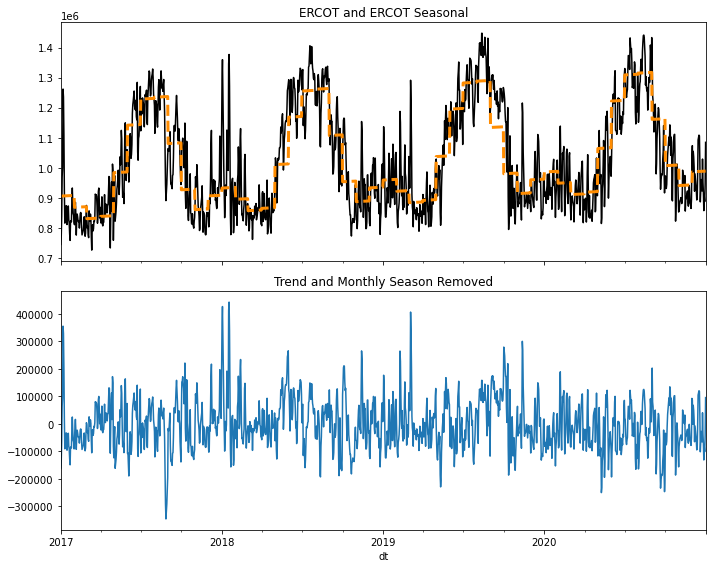

In [9]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

load.plot(y="ERCOT", ax=ax[0], color="k", legend=False)
load.plot(
    y="ERCOT_trend_mseasonal", ax=ax[0], color="DarkOrange",
    linestyle="--", legend=False, linewidth=3
)
ax[0].set_title("ERCOT and ERCOT Seasonal")

load.plot(y="ERCOT_trend_mseasonal_removed", ax=ax[1], legend=False)
ax[1].set_title("Trend and Monthly Season Removed")

fig.tight_layout()

**Daily seasonality**

In [10]:
# Get fixed effect values for each "season" of our choosing
dows = list(range(7))
dow_cols = [f"day_{i}" for i in dows]

for dow in dow_cols:
    _, i = dow.split("_")
    i = int(i)

    load[dow] = (load.index.dayofweek == i).astype(int)


In [11]:
mod_seas_d = LinearRegression(fit_intercept=False)
mod_seas_d.fit(load.loc[:, dow_cols], load["ERCOT_trend_mseasonal_removed"])

load["ERCOT_dseasonal"] = mod_seas_d.predict(load.loc[:, dow_cols])
load["ERCOT_trend_mdseasonal"] = load.eval("ERCOT_trend_mseasonal + ERCOT_dseasonal")
load["ERCOT_trend_mdseasonal_removed"] = load.eval("ERCOT_trend_mseasonal_removed - ERCOT_dseasonal")

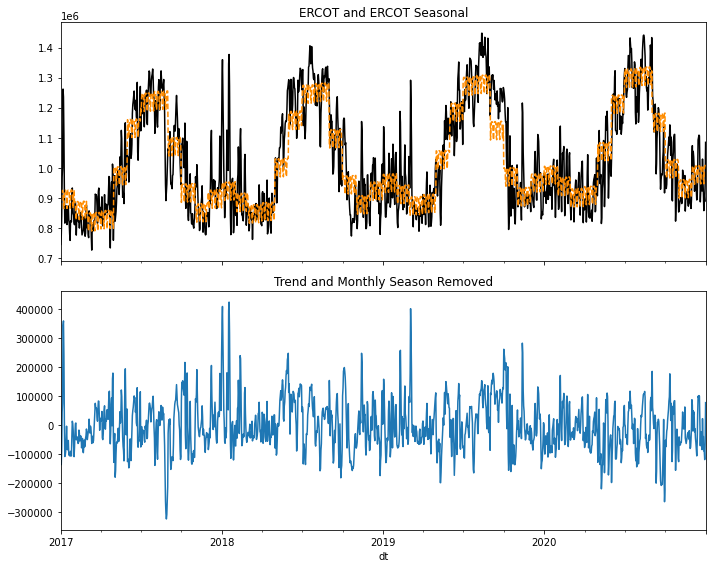

In [12]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

load.plot(y="ERCOT", ax=ax[0], color="k", legend=False)
load.plot(y="ERCOT_trend_mdseasonal", ax=ax[0], color="DarkOrange", linestyle="--", legend=False)
ax[0].set_title("ERCOT and ERCOT Seasonal")

load.plot(y="ERCOT_trend_mdseasonal_removed", ax=ax[1], legend=False)
ax[1].set_title("Trend and Monthly Season Removed")

fig.tight_layout()

## Fitting an ARMA model to remainder

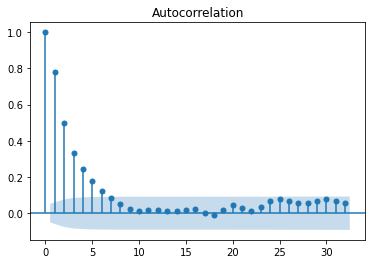

In [13]:
plot_acf(load.loc[:, "ERCOT_trend_mdseasonal_removed"]);

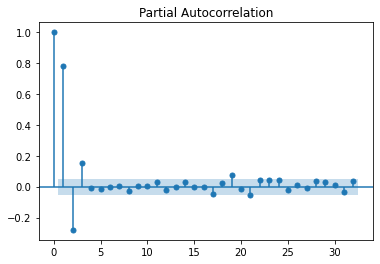

In [14]:
plot_pacf(load.loc[:, "ERCOT_trend_mdseasonal_removed"]);

In [15]:
arma = ARIMA(load.loc[:, "ERCOT_trend_mdseasonal_removed"], order=(3, 0, 3))
arma_res = arma.fit()

print(arma_res.summary())

/home/chase/anaconda3/envs/teaching/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/chase/anaconda3/envs/teaching/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/chase/anaconda3/envs/teaching/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:     ERCOT_trend_mdseasonal_removed   No. Observations:                 1461
Model:                             ARIMA(3, 0, 3)   Log Likelihood              -17963.251
Date:                            Tue, 22 Mar 2022   AIC                          35942.503
Time:                                    17:47:39   BIC                          35984.798
Sample:                                01-01-2017   HQIC                         35958.280
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.896e-08   5534.482  -3.43e-12      1.000   -1.08e+04    1.08e+04
ar.L1          0.6022      0.175   

/home/chase/anaconda3/envs/teaching/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecasting 2021

In [17]:
load_2021 = pd.read_parquet("load_2017_2022.parquet").loc["2021"]
nobs_2021 = load_2021.shape[0]

load_2021.head()

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
dt,,,,,,,,,
2021-01-01,271953.882559,41190.804193,93813.389132,21243.560972,353825.717397,81417.019898,172345.970777,32246.511313,1.068037e+06
2021-01-02,272462.764546,38885.322418,91632.123074,19135.835575,312524.004589,72479.823159,159354.261110,30312.165093,9.967863e+05
2021-01-03,259619.544690,38036.015179,90470.167098,18632.273741,292306.758481,71408.046869,153297.981501,28300.127514,9.520709e+05
2021-01-04,261534.667572,36584.497765,90009.063029,18764.753615,296626.043012,70172.353080,149537.672469,28283.098882,9.515121e+05
2021-01-05,258456.470254,37000.337019,92038.103093,18689.908336,297387.377764,69235.466516,144685.239774,27831.490538,9.453244e+05


**Predicting each component**

In [18]:
arma_res_forecast = arma_res.get_forecast(nobs_2021)
arma_forecast = arma_res_forecast.predicted_mean

In [19]:
trend_tvalues_forecast = (trend_tvalues[-1] + 1) + np.arange(load_2021.shape[0])

trend_forecast = mod_trend.predict(trend_tvalues_forecast[:, None])

In [20]:
# Get fixed effect values for each month
for month in month_cols:
    _, i = month.split("_")
    i = int(i)

    load_2021[month] = (load_2021.index.month == i).astype(int)

month_forecast = mod_seas_m.predict(load_2021.loc[:, month_cols])

In [21]:
# Get fixed effect values for each day of week
for dow in dow_cols:
    _, i = dow.split("_")
    i = int(i)

    load_2021[dow] = (load_2021.index.dayofweek == i).astype(int)

dow_forecast = mod_seas_d.predict(load_2021.loc[:, dow_cols])

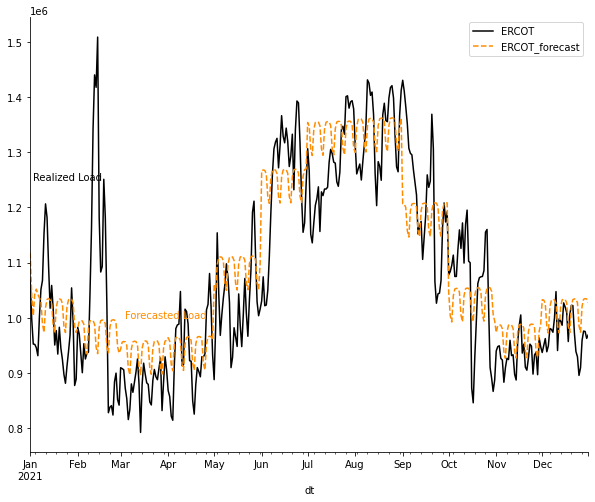

In [22]:
load_2021["ERCOT_forecast"] = trend_forecast + month_forecast + dow_forecast + arma_forecast

fig, ax = plt.subplots(figsize=(10, 8))

load_2021.plot(y="ERCOT", ax=ax, color="k")
load_2021.plot(y="ERCOT_forecast", ax=ax, color="DarkOrange", linestyle="--")

ax.annotate("Realized Load", xy=(18630, 1250000))
ax.annotate("Forecasted Load", xy=(18690, 1000000), color="DarkOrange")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

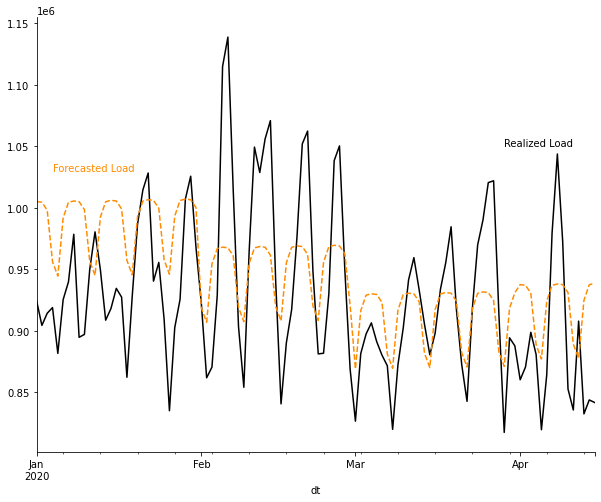

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

load.loc["2020-01-01":"2020-04-15", :].plot(
    y="ERCOT", ax=ax, color="k", legend=False
)
load.loc["2020-01-01":"2020-04-15", :].plot(
    y="ERCOT_trend_mdseasonal", ax=ax,
    color="DarkOrange", linestyle="--", legend=False
)

ax.annotate("Realized Load", xy=(18350, 1050000))
ax.annotate("Forecasted Load", xy=(18265, 1030000), color="DarkOrange")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)